<a href="https://colab.research.google.com/github/xtenix88/Data-Portfolio/blob/main/Ichimoku_Cloud_Optimal_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##INTRODUCTION

This project is not set out to recommend any stocks. I'm not a trader, not even close. However, it is my interest to learn more about how to read stock charts and using technical indicators and see how it compare to trade based on speculation and news (of course, these two create volatility offering short term opportunities). I learned many of the code below from Derek Banas, an Udemy instructor. I recommend anyone interested in the same topic NOT to just copy the code. It helps to type out all the code, google/stackoverflow anything you don't understand, and most importantly, google the concept behind ichimoku cloud, moving average, etc.  Once you have a more than a basic understanding of the concept and the code, try to use the code to build your own portfolio and use the ichimoku cloud to test few trades. The data I used is a 5 year data, but it's good idea to run a 6 month and 1 year analysis to compare/analyze with the 5 year analysis. I didn't do it here so this notebook will be super long!

I only scratched the surface and there are so much more to learn! I will be continuing to learn more, create a Tableau visulization on the EDA, and building up this project 😃.

The data is from yfinance and https://www.nasdaq.com/market-activity/stocks/screener


The code is seperated into 3 parts:

1.  EDA on NYSE and NASDAQ

2.  Downloading Stock Data and Building the Ichimoku Cloud.

3.  Finding a Optimal Portfolio with Sharpe Ratio.





**Sidenote:** Due to the amount of time it required to download all the stocks from NASDAQ, I only picked the top 200 based on market cap. Of course, you can run on all of the NASDAQ tickers if you would like. 

**Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import time
import os
import seaborn as sns

**Obtain Stock Data from Yahoo Finance**

In [ ]:
pip install yfinance

     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 6.4 MB 5.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf

**Set Start and End Date**

In [ ]:
# Start end date defaults
S_DATE = "2017-02-01"
E_DATE = "2023-02-01"
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

**Getting the CSV on Some of My Selected Tickers**

In [ ]:
tickers = ['AMZN', 'COST', 'ADBE', 'QQQ', 'NVDA', 'VUG', 'VGT', 'VOO', 'SPY', 'ARKK', 'ADBE','NVDA', 'AMD', 'MSFT', 'DIS', 'WMT', 'TGT', 'HD']

for ticker in tickers:
  stock = yf.Ticker(ticker)
  df = stock.history(period="5y")
  df.sort_index(axis = 0.,  ascending=False)
  df.to_csv(ticker + '.csv')


##EDA on NASDAQ and NYSE

The goal of this notebook is to code the ichimoku cloud and finding a optimal portfolio based on cumulative returns. We run a EDA on the dataset, but may not impute or change or fill in some of the missing values. 

Data source: https://www.nasdaq.com/market-activity/stocks/screener

In [ ]:
nasdaq = pd.read_csv("/content/Nasdaq.csv")
nasdaq.head(3)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$172.79,3.91,2.32%,3.000000e+12,United States,1980.0,62473258,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$300.47,5.47,1.85%,2.250000e+12,United States,1986.0,26739593,Technology,Computer Software: Prepackaged Software
2,GOOGL,Alphabet Inc. Class A Common Stock,"$2,732.17",21.65,0.80%,1.810000e+12,United States,NaN,1319869,Technology,Internet and Information Services


In [ ]:
nasdaq.shape

(8414, 11)

In [ ]:
nasdaq.dtypes

#IPO Year is in float64, most likely due to NaN values. 

Symbol         object
Name           object
Last Sale      object
Net Change    float64
% Change       object
Market Cap    float64
Country        object
IPO Year      float64
Volume          int64
Sector         object
Industry       object
dtype: object

In [ ]:
# Missing values

percent_missing = nasdaq.isnull().sum() * 100 / len(nasdaq)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values(by=['percent_missing'], ascending=False)

#nasdaq[nasdaq.isna().any(axis=1)]

,percent_missing
IPO Year,40.373188
Sector,26.194438
Industry,26.016164
Country,9.424768
Market Cap,5.585928
% Change,0.071310
Symbol,0.000000
Name,0.000000
Last Sale,0.000000
Net Change,0.000000


In [ ]:
# Duplicate values
percentage = nasdaq.duplicated(keep=False).value_counts(normalize=True) * 100
percentage

False    100.0
dtype: float64

In [ ]:
nasdaq.describe()

,Net Change,Market Cap,IPO Year,Volume
count,8414.000000,7.944000e+03,5017.000000,8.414000e+03
mean,0.858206,8.048253e+09,2014.940403,1.006303e+06
std,17.360950,6.181705e+10,8.940584,4.450063e+06
min,-86.160000,0.000000e+00,1972.000000,1.000000e+00
25%,0.000000,5.564069e+07,2013.000000,1.488175e+04
50%,0.110000,3.724824e+08,2019.000000,1.103035e+05
75%,0.560000,2.265847e+09,2021.000000,5.547030e+05
max,1570.000000,3.000000e+12,2022.000000,1.795731e+08


In [ ]:
nasdaq.columns

Index(['Symbol', 'Name', 'Last Sale', 'Net Change', '% Change', 'Market Cap',
       'Country', 'IPO Year', 'Volume', 'Sector', 'Industry'],
      dtype='object')

In [ ]:
#print(nasdaq['Sector'].value_counts())
print(nasdaq['Sector'].value_counts(normalize=True)*100)

Finance                  26.586151
Health Care              18.550725
Technology               13.558776
Consumer Services        12.061192
Capital Goods             7.697262
Consumer Non-Durables     3.768116
Energy                    3.510467
Public Utilities          3.446055
Basic Industries          3.317230
Miscellaneous             3.011272
Consumer Durables         2.560386
Transportation            1.932367
Name: Sector, dtype: float64


Rows, Columns: (8414, 11)


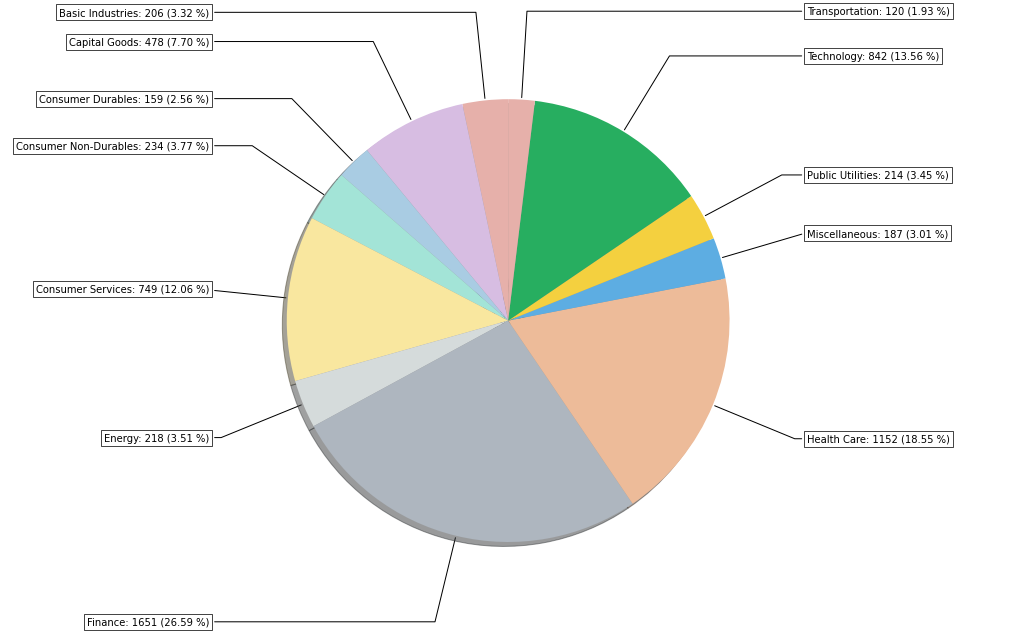

In [ ]:
print("Rows, Columns:",nasdaq.shape)
Sector = nasdaq.groupby('Sector').size()
labels = Sector.index.values
sizes = Sector.values
muestra = []
for k in range(0,labels.size):
  texto = labels[k]+': '+str(sizes[k])+' ({:,.2f} %)'.format((100*sizes[k]/sum(sizes)))
  muestra.append(texto)
colors = ['#E6B0AA','#D7BDE2','#A9CCE3','#A3E4D7','#F9E79F','#D5DBDB','#AEB6BF','#EDBB99','#5DADE2','#F4D03F','#27AE60']
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
fig,ax1 = plt.subplots(figsize=(18,9),ncols=1,nrows=1)
wedges, texts = ax1.pie(sizes, shadow=True, colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax1.annotate(muestra[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.show()

In [ ]:
nasdaq['Industry'].groupby(nasdaq['Sector']).value_counts()


Sector            Industry                
Basic Industries  Major Chemicals             32
                  Precious Metals             31
                  Steel/Iron Ore              28
                  Industrial Specialties      27
                  Agricultural Chemicals      12
                                              ..
Transportation    Railroads                    5
                  Hotels/Resorts               2
                  Advertising                  1
                  Rental/Leasing Companies     1
                  Transportation Services      1
Name: Industry, Length: 223, dtype: int64

In [ ]:
country = nasdaq['Country'].value_counts()
country[0:21] 

United States     6308
China              230
Canada             228
Israel             118
United Kingdom      99
Bermuda             70
Cayman Islands      62
Hong Kong           49
Greece              34
Brazil              32
Switzerland         30
Netherlands         28
Singapore           27
Germany             24
Mexico              23
Ireland             22
France              17
Australia           16
Argentina           16
Luxembourg          15
Malaysia            12
Name: Country, dtype: int64

In [ ]:
nyse = pd.read_csv("/content/NYSE.csv")
nyse.head(3)

,Ticker,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$135.91,0.70,0.52%,4.082276e+10,United States,1999.0,2368248,Capital Goods,Electrical Products
1,AA,Alcoa Corporation Common Stock,$74.04,0.18,0.24%,1.363075e+10,NaN,2016.0,6819279,Basic Industries,Metal Fabrications
2,AAC,Ares Acquisition Corporation Class A Ordinary ...,$9.75,0.01,0.10%,1.218750e+09,NaN,2021.0,88047,Finance,Business Services


In [ ]:
nyse.shape

(3183, 11)

In [ ]:
# Missing values

percent_missing = nyse.isnull().sum() * 100 / len(nyse)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values(by=['percent_missing'], ascending=False)

#nasdaq[nasdaq.isna().any(axis=1)]

,percent_missing
IPO Year,46.685517
Sector,26.453032
Industry,26.264530
Country,22.965756
Market Cap,14.043355
Ticker,0.000000
Name,0.000000
Last Sale,0.000000
Net Change,0.000000
% Change,0.000000


In [ ]:
nyse.describe()

,Net Change,Market Cap,IPO Year,Volume
count,3183.000000,2.736000e+03,1697.000000,3.183000e+03
mean,1.273917,1.327673e+10,2012.660577,1.377164e+06
std,27.965390,4.004990e+10,9.131653,4.984651e+06
min,-31.990000,0.000000e+00,1986.000000,1.000000e+00
25%,0.002800,4.018503e+08,2007.000000,3.711650e+04
50%,0.180000,1.755592e+09,2016.000000,2.349100e+05
75%,0.775000,7.984638e+09,2020.000000,9.886290e+05
max,1570.000000,6.457610e+11,2022.000000,1.811841e+08


In [ ]:
#print(nyse['Sector'].value_counts())
print(nyse['Sector'].value_counts(normalize=True)*100)

Finance                  30.499786
Consumer Services        16.275096
Technology                9.611277
Capital Goods             9.568560
Public Utilities          6.236651
Energy                    5.980350
Basic Industries          5.425032
Health Care               5.168731
Consumer Non-Durables     4.186245
Miscellaneous             2.819308
Transportation            2.648441
Consumer Durables         1.580521
Name: Sector, dtype: float64


Rows, Columns: (3183, 11)


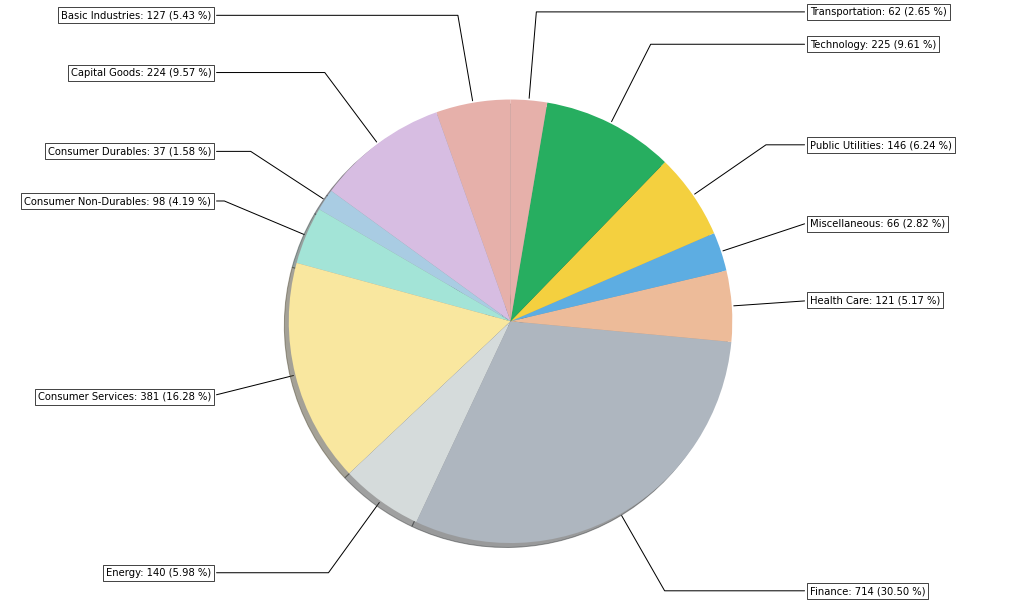

In [ ]:
print("Rows, Columns:",nyse.shape)
Sector = nyse.groupby('Sector').size()
labels = Sector.index.values
sizes = Sector.values
muestra = []
for k in range(0,labels.size):
  texto = labels[k]+': '+str(sizes[k])+' ({:,.2f} %)'.format((100*sizes[k]/sum(sizes)))
  muestra.append(texto)
colors = ['#E6B0AA','#D7BDE2','#A9CCE3','#A3E4D7','#F9E79F','#D5DBDB','#AEB6BF','#EDBB99','#5DADE2','#F4D03F','#27AE60']
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
fig,ax1 = plt.subplots(figsize=(18,9),ncols=1,nrows=1)
wedges, texts = ax1.pie(sizes, shadow=True, colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax1.annotate(muestra[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.show()

In [ ]:
country = nyse['Country'].value_counts()
country[0:21] 

United States     2063
Canada              71
Bermuda             49
China               36
United Kingdom      28
Brazil              20
Greece              16
Switzerland         13
Netherlands         11
Monaco              10
Mexico              10
Argentina           10
Cayman Islands       9
Japan                9
Chile                8
South Korea          8
Ireland              8
India                8
Luxembourg           8
South Africa         6
Singapore            4
Name: Country, dtype: int64

**Downloading the Tickers from NASDAQ.csv**

In [ ]:
def get_column_from_csv(file, col_name):
    # Try to get the file and if it doesn't exist issue a warning
    try:
        df = pd.read_csv(file)
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df[col_name]

In [ ]:
tickers = get_column_from_csv("/content/Nasdaq.csv", "Symbol")
print(len(tickers))
tickers

8414


0         AAPL
1         MSFT
2        GOOGL
3         GOOG
4         AMZN
         ...  
8409     WRB^G
8410     WRB^H
8411     WSO/B
8412    XFLT^A
8413    YCBD^A
Name: Symbol, Length: 8414, dtype: object

In [ ]:
def save_to_csv_from_yahoo(folder, ticker):
    stock = yf.Ticker(ticker)
    
    try:
        print("Get Data for : ", ticker)
        # Get historical closing price data
        df = stock.history(period="5y")
    
        # Wait 2 seconds
        time.sleep(2)
        
        # Remove the period for saving the file name
        # Save data to a CSV file
        # File to save to 
        the_file = folder + ticker.replace(".", "_") + '.csv'
        print(the_file, " Saved")
        df.to_csv(the_file)
    except Exception as ex:
        print("Couldn't Get Data for :", ticker)

In [ ]:
PATH = "/content/"

*Due to the amount of tickers and the run time required for the code. I ran the top 199 tickers only in the NASDAQ base on market cap.*

In [ ]:
for x in range(0, 200):
    save_to_csv_from_yahoo(PATH, tickers[x])
    print("Finished")

Get Data for :  AAPL
/content/AAPL.csv  Saved
Finished
Get Data for :  MSFT
/content/MSFT.csv  Saved
Finished
Get Data for :  GOOGL
/content/GOOGL.csv  Saved
Finished
Get Data for :  GOOG
/content/GOOG.csv  Saved
Finished
Get Data for :  AMZN
/content/AMZN.csv  Saved
Finished
Get Data for :  TSLA
/content/TSLA.csv  Saved
Finished
Get Data for :  NVDA
/content/NVDA.csv  Saved
Finished
Get Data for :  TSM
/content/TSM.csv  Saved
Finished
Get Data for :  FB
/content/FB.csv  Saved
Finished
Get Data for :  V
/content/V.csv  Saved
Finished
Get Data for :  JPM
/content/JPM.csv  Saved
Finished
Get Data for :  UNH
/content/UNH.csv  Saved
Finished
Get Data for :  JNJ
/content/JNJ.csv  Saved
Finished
Get Data for :  BAC
/content/BAC.csv  Saved
Finished
Get Data for :  PG
/content/PG.csv  Saved
Finished
Get Data for :  MA
/content/MA.csv  Saved
Finished
Get Data for :  WMT
/content/WMT.csv  Saved
Finished
Get Data for :  HD
/content/HD.csv  Saved
Finished
Get Data for :  BABA
/content/BABA.csv  Sa

In [ ]:
def get_stock_df_from_csv(tickers):
  try:
    df = pd.read_csv(PATH + tickers + '.csv', index_col=0)
  except FileNotFoundError:
    print("File Doesn't Exist")
  else:
    return df

In [ ]:
get_stock_df_from_csv('COST')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-02-17,156.828298,157.748871,155.943470,157.176865,2424400,0.0,0
2017-02-21,157.793584,158.195774,157.302013,158.142151,2317000,0.0,0
2017-02-22,158.258346,158.276211,156.470823,157.757828,1815200,0.0,0
2017-02-23,157.766772,158.231518,156.595947,157.167953,2599900,0.0,0
2017-02-24,156.604845,158.830316,156.515464,158.696243,1684300,0.0,0
...,...,...,...,...,...,...,...
2022-02-10,520.869995,524.469971,514.750000,518.479980,2558900,0.0,0
2022-02-11,518.400024,521.349976,507.380005,509.670013,2348800,0.0,0
2022-02-14,508.989990,511.529999,501.440002,506.559998,1720300,0.0,0


In [ ]:
from os import listdir
from os.path import isfile, join

files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
len(tickers)

208

In [ ]:
def add_daily_return_to_df(df):
  df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
  return df

In [ ]:
def add_cum_return_to_df(df):
  df['cum_return'] = (1 + df['daily_return']).cumprod()
  return df

In [ ]:
def add_bollinger_bands(df):
  df['middle_band'] = df['Close'].rolling(window=20).mean()
  df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
  df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()
  return df

In [ ]:
def add_ichimoku(df):
  #Conversion line
  hi_val = df['High'].rolling(window=9).max()
  lo_val = df['Low'].rolling(window=9).min()
  df['Conversion'] = (hi_val+lo_val)/2

  #Base Line
  hi_val2 = df['High'].rolling(window=26).max()
  lo_val2 = df['Low'].rolling(window=26).min()
  df['Baseline'] = (hi_val2+lo_val2)/2

  #Span A
  df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2)

  #Span B
  hi_val3 = df['High'].rolling(window=52).max()
  lo_val3 = df['Low'].rolling(window=52).min()
  df['SpanB'] = ((hi_val3 + lo_val3)/2).shift(26)

  #Laggine Span
  df['Lagging'] = df['Close'].shift(-26)
  return df



##What is the Ichimoku Cloud?

Ichimoku is a technical indicator. The 5 lines of the cloud are:

1. Tenkan Sen = Conversion Line: determine the direction of the short-term trend (yellow). Faster line. 
2. Kijun Sen = Base Line: avg for medium point and shows mid-term trend (red). Slower line.
3. Senkou Span A = Leading Span A (green)
4. Senkou Span B = Leading Span B (red)
5. Chikou Line = Lagging Span (teal): helps to confirm signal.


Few important concepts:
1. Formed between Span A and Span B, the **cloud** shows support and resistance.
2. Span A and Span B are set 26 periods into the future.  
3. Chikou represents the closing price and set 26 periods in the past. 
4. Wider the cloud, the stronger the trend. 
5. Try to not use the strategy for less than 1 hour. 


Reading the cloud:
1. Price is above the cloud: UP trend. Green color. Top of cloud is the support. 
2. Price is below the cloud: DOWN trend. Red color. Bottom of cloud is the resistant. 
3. Not recommended to trade when price is inside the cloud. Market is not trending. Use top of cloud as resistance and bottom as support. 
4. Tk/Golden Cross: when conversion past base from bottom to up, a **BUY** signal. If the price is above the cloud during this cross, it is a strong buy signal. If the price is below the cloud, you may want to wait until price is on top of the cloud. If the lagging span is crossing the price at the same time at the same direction, it's also another signal on buy. Set the stop loss at the narest local minimum.
5. Death Cross: when conversion past base from top to bottom, a **SELL** signal. If the price is below the cloud during this cross, it is a strong sell signal. If the price is above the cloud, you may want to wait until price is on bottom of the cloud before entering short positions. Set the stop loss at the narest local maximum.

Strategy Visualization: [ichimoku](https://yukiphotostudio.pixieset.com/ichimoku/)

In [ ]:
for x in tickers:
  try:
    print("Working on:", x)
    new_df = get_stock_df_from_csv(x)
    new_df = add_daily_return_to_df(new_df)
    new_df = add_cum_return_to_df(new_df)
    new_df = add_bollinger_bands(new_df)
    new_df = add_ichimoku(new_df)
    new_df.to_csv(PATH + x + '.csv')
  except Exception as ex:
    print(ex)

Working on: ABB
Working on: DUK
Working on: AMD
Working on: ETN
Working on: MRNA
Working on: ENB
Working on: FCX
Working on: GE
Working on: ACN
Working on: TSM
Working on: LMT
Working on: UL
Working on: MCO
Working on: TD
Working on: EL
Working on: MO
Working on: JNJ
Working on: UBER
Working on: MMC
Working on: KO
Working on: WM
Working on: CVX
Working on: DHR
Working on: CRM
Working on: FDX
Working on: HSBC
Working on: AZN
Working on: COF
Working on: CCI
Working on: SONY
Working on: NVO
Working on: RIO
Working on: SQ
Working on: V
Working on: SPGI
Working on: SNY
Working on: PEP
Working on: SCHW
Working on: PM
Working on: WFC
Working on: CI
Working on: BAC
Working on: UPS
Working on: EQNR
Working on: LLY
Working on: TFC
Working on: JD
Working on: QCOM
Working on: ARKK
Working on: SPY
Working on: AMGN
Working on: PYPL
Working on: DIS
Working on: TSLA
Working on: PG
Working on: AMOV
Working on: T
Working on: CB
Working on: STLA
Working on: BABA
Working on: GOOGL
Working on: GOOG
Working

**Testing on Costco stock**

In [ ]:
df = pd.read_csv('/content/COST.csv', index_col=0)

#daily return
df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1

#cumulative return
df['cum_return'] = (1 + df['daily_return']).cumprod()

#moving average 20 days
df['middle_band'] = df['Close'].rolling(window=20).mean()
df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()

#Conversion line
hi_val = df['High'].rolling(window=9).max()
lo_val = df['Low'].rolling(window=9).min()
df['Conversion'] = (hi_val+lo_val)/2

#Base Line
hi_val2 = df['High'].rolling(window=26).max()
lo_val2 = df['Low'].rolling(window=26).min()
df['Baseline'] = (hi_val2+lo_val2)/2

#Span A
df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2)

#Span B
hi_val3 = df['High'].rolling(window=52).max()
lo_val3 = df['Low'].rolling(window=52).min()
df['SpanB'] = ((hi_val3 + lo_val3)/2).shift(26)

#Laggine Span
df['Lagging'] = df['Close'].shift(-26)

#return df
df


,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_return,cum_return,middle_band,upper_band,lower_band,Conversion,Baseline,SpanA,SpanB,Lagging
Date,,,,,,,,,,,,,,,,,
2017-02-17,156.828298,157.748871,155.943470,157.176865,2424400,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.052567
2017-02-21,157.793584,158.195774,157.302013,158.142151,2317000,0.0,0,0.006141,1.006141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.642471
2017-02-22,158.258346,158.276211,156.470823,157.757828,1815200,0.0,0,-0.002430,1.003696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.053604
2017-02-23,157.766772,158.231518,156.595947,157.167953,2599900,0.0,0,-0.003739,0.999943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.874863
2017-02-24,156.604845,158.830316,156.515464,158.696243,1684300,0.0,0,0.009724,1.009667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.990021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-10,520.869995,524.469971,514.750000,518.479980,2558900,0.0,0,-0.019572,3.298704,501.907178,536.158241,467.656114,512.063752,516.247559,514.155656,519.119345,NaN
2022-02-11,518.400024,521.349976,507.380005,509.670013,2348800,0.0,0,-0.016992,3.242653,501.585789,535.411614,467.759965,515.213971,510.491300,512.852636,523.849531,NaN
2022-02-14,508.989990,511.529999,501.440002,506.559998,1720300,0.0,0,-0.006102,3.222866,501.802350,535.698012,467.906688,517.839996,507.920163,512.880080,524.313070,NaN


In [ ]:
def plot_with_boll_bands(df, ticker):
  fig = go.Figure()

  candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

  upper_line = go.Scatter(x=df.index, y=df['upper_band'], 
                          line=dict(color='rgba(250,0,0,0.75)',
                          width=1), name='Upper Band')

  mid_line = go.Scatter(x=df.index, y=df['middle_band'], 
                          line=dict(color='rgba(0,0,250,0.75)',
                          width=1), name='Middle Band')
  
  lower_line = go.Scatter(x=df.index, y=df['lower_band'], 
                          line=dict(color='rgba(0,25,0,0.75)',
                          width=1), name='Lower Band')
  
  fig.add_trace(candle)
  fig.add_trace(upper_line)
  fig.add_trace(mid_line)
  fig.add_trace(lower_line)

  fig.update_xaxes(title='Date', rangeslider_visible=True)
  fig.update_yaxes(title='Price')

  fig.update_layout(title="Bollinger Bands", height=1200, width=1800, showlegend=True)

  fig.show()

In [ ]:
import plotly.graph_objs as go

fig = go.Figure()

candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

upper_line = go.Scatter(x=df.index, y=df['upper_band'], 
                          line=dict(color='rgba(250,0,0,0.75)',
                          width=1), name='Upper Band')

mid_line = go.Scatter(x=df.index, y=df['middle_band'], 
                          line=dict(color='rgba(0,0,250,0.75)',
                          width=1), name='Middle Band')
  
lower_line = go.Scatter(x=df.index, y=df['lower_band'], 
                          line=dict(color='rgba(0,25,0,0.75)',
                          width=1), name='Lower Band')
  
fig.add_trace(candle)
fig.add_trace(upper_line)
fig.add_trace(mid_line)
fig.add_trace(lower_line)

fig.update_xaxes(title='Date', rangeslider_visible=True)
fig.update_yaxes(title='Price')

fig.update_layout(title="Bollinger Bands", height=800, width=1200, showlegend=True)

#fig.show()

In [ ]:
def get_fill_color(label):
    if label >= 1:
        return 'rgba(0,250,0,0.2)'
    else:
        return 'rgba(250,0,0,0.2)'

In [ ]:
def get_ichimoku(df):
  candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

  df1 = df.copy()
  fig = go.Figure()
  df['label'] = np.where(df['SpanA'] > df['SpanB'], 1, 0) #return 1 for green, return 0 for red
  df['group'] = df['label'].ne(df['label'].shift()).cumsum()
  df = df.groupby('group')

  dfs = []
  for name, data in df:
    dfs.append(data)
  for df in dfs:
    fig.add_traces(go.Scatter(x=df.index, y=df.SpanA,
        line=dict(color='rgba(0,0,0,0)')))

    fig.add_traces(go.Scatter(x=df.index, y=df.SpanB,
        line=dict(color='rgba(0,0,0,0)'),
        fill='tonexty',
        fillcolor=get_fill_color(df['label'].iloc[0])))
    
  baseline = go.Scatter(x=df1.index, y=df1['Baseline'],
                        line=dict(color='red', width=3), name='Baseline')
  
  conversion = go.Scatter(x=df1.index, y=df1['Conversion'],
                          line=dict(color='gold', width=3), name='Conversion')
  
  lagging = go.Scatter(x=df1.index, y=df1['Lagging'],
                          line=dict(color='purple', width=2), name='Lagging')
  
  span_a = go.Scatter(x=df1.index, y=df1['SpanA'],
                          line=dict(color='green', width=2, dash='dot'), name='Span A')
  
  span_b = go.Scatter(x=df1.index, y=df1['SpanB'],
                          line=dict(color='red', width=2, dash='dot'), name='Span B')
  
  fig.add_trace(candle)
  fig.add_trace(baseline)
  fig.add_trace(conversion)
  fig.add_trace(lagging)
  fig.add_trace(span_a)
  fig.add_trace(span_b)

  fig.update_layout(height=800, width=1300, showlegend=True)

  fig.show()



In [ ]:
tesla = get_stock_df_from_csv('COST')
get_ichimoku(tesla)

##Optimal Portfolio

In [ ]:
#sec_df = pd.read_csv('/content/big_stock_sectors.csv')
sec_df = pd.read_csv('/content/Nasdaq.csv')

In [ ]:
sec_df.rename(columns={'Symbol': 'Ticker'}, inplace=True)


In [ ]:
sec_df.head()

,Ticker,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$172.79,3.91,2.32%,3.000000e+12,United States,1980.0,62473258,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$300.47,5.47,1.85%,2.250000e+12,United States,1986.0,26739593,Technology,Computer Software: Prepackaged Software
2,GOOGL,Alphabet Inc. Class A Common Stock,"$2,732.17",21.65,0.80%,1.810000e+12,United States,NaN,1319869,Technology,Internet and Information Services
3,GOOG,Alphabet Inc. Class C Capital Stock,"$2,728.51",22.51,0.83%,1.800000e+12,United States,2004.0,1313677,Technology,Internet and Information Services
4,AMZN,Amazon.com Inc. Common Stock,"$3,130.21",26.87,0.87%,1.590000e+12,United States,1997.0,2815676,Consumer Services,Catalog/Specialty Distribution


In [ ]:
sec_df['Sector'].value_counts()

Finance                  1651
Health Care              1152
Technology                842
Consumer Services         749
Capital Goods             478
Consumer Non-Durables     234
Energy                    218
Public Utilities          214
Basic Industries          206
Miscellaneous             187
Consumer Durables         159
Transportation            120
Name: Sector, dtype: int64

In [ ]:
finance_df = sec_df.loc[sec_df['Sector'] == "Finance"]
health_df = sec_df.loc[sec_df['Sector'] == "Health Care"]
tech_df = sec_df.loc[sec_df['Sector'] == "Technology"]
consumer_df = sec_df.loc[sec_df['Sector'] == "Consumer Services"]
goods_df = sec_df.loc[sec_df['Sector'] == "Capital Goods"]
nondurables_df = sec_df.loc[sec_df['Sector'] == "Consumer Non-Durables"]
energy_df = sec_df.loc[sec_df['Sector'] == "Energy"]
public_utilities_df = sec_df.loc[sec_df['Sector'] == "Public Utilities"]
industries_df = sec_df.loc[sec_df['Sector'] == "Basic Industries"]
misc_df = sec_df.loc[sec_df['Sector'] == "Miscellaneous"]
durables_df = sec_df.loc[sec_df['Sector'] == "Consumer Durables"]
transportation_df = sec_df.loc[sec_df['Sector'] == "Transportation"]


In [ ]:
tech_df

,Ticker,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$172.79,3.9100,2.32%,3.000000e+12,United States,1980.0,62473258,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$300.47,5.4700,1.85%,2.250000e+12,United States,1986.0,26739593,Technology,Computer Software: Prepackaged Software
2,GOOGL,Alphabet Inc. Class A Common Stock,"$2,732.17",21.6500,0.80%,1.810000e+12,United States,NaN,1319869,Technology,Internet and Information Services
3,GOOG,Alphabet Inc. Class C Capital Stock,"$2,728.51",22.5100,0.83%,1.800000e+12,United States,2004.0,1313677,Technology,Internet and Information Services
6,NVDA,NVIDIA Corporation Common Stock,$264.95,22.2800,9.18%,6.620000e+11,United States,1999.0,69539716,Technology,Semiconductors
...,...,...,...,...,...,...,...,...,...,...,...
7780,STRNW,Stran & Company Inc. Warrant,$0.37,0.0112,3.11%,0.000000e+00,United States,2021.0,36192,Technology,Advertising
7782,SURGW,SurgePays Inc. Warrant,$0.70,-0.0499,-6.65%,0.000000e+00,United States,NaN,7595,Technology,Computer Software: Prepackaged Software
7844,TRKAW,Troika Media Group Inc. Warrant,$0.26,0.0199,8.29%,0.000000e+00,United States,2021.0,12045,Technology,Advertising
7876,VENAW,Venus Acquisition Corporation Warrant,$0.11,-0.0357,-24.50%,0.000000e+00,United States,2021.0,2618,Technology,EDP Services


In [ ]:
def get_cum_ret_for_stocks(stock_df):
    tickers = []
    cum_rets = []

    for index, row in stock_df.iterrows():
        df = get_stock_df_from_csv(row['Ticker'])
        if df is None:
            pass
        else:
            tickers.append(row['Ticker'])
            cum = df['cum_return'].iloc[-1]
            cum_rets.append(cum)
    return pd.DataFrame({'Ticker':tickers, 'CUM_RET':cum_rets})

In [ ]:
finance_df = get_cum_ret_for_stocks(finance_df)
health_df = get_cum_ret_for_stocks(health_df)
tech_df = get_cum_ret_for_stocks(tech_df)
consumer_df = get_cum_ret_for_stocks(consumer_df)
goods_df = get_cum_ret_for_stocks(goods_df)
nondurables_df = get_cum_ret_for_stocks(nondurables_df)
energy_df = get_cum_ret_for_stocks(energy_df)
public_utilities_df = get_cum_ret_for_stocks(public_utilities_df)
industries_df = get_cum_ret_for_stocks(industries_df)
misc_df = get_cum_ret_for_stocks(misc_df)
durables_df = get_cum_ret_for_stocks(durables_df)
transportation_df = get_cum_ret_for_stocks(transportation_df)


Streaming output truncated to the last 5000 lines.
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist

**Cumulative Return Performance Per Sector**

In [ ]:
print('Finance:')
print(finance_df .sort_values(by=['CUM_RET'], ascending=False).head(10))



Finance:
   Ticker   CUM_RET
12     BX  5.417387
25    PGR  3.242527
6     AXP  2.675970
20    IBN  2.670437
26    AON  2.550086
3      MS  2.484640
11    AMT  2.369492
22    ICE  2.289136
16    CME  2.287890
4    SCHW  2.286101


In [ ]:
print('Health:')
print(health_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Health:
   Ticker   CUM_RET
28   MRNA  8.161828
20    ZTS  3.829660
25     EW  3.699354
18   ISRG  3.615848
4     LLY  3.394068
0     UNH  3.284303
9     DHR  3.264887
5     NVO  3.231779
23    HCA  3.094293
17   ANTM  3.047290


In [ ]:
print('Tech:')
print(tech_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Tech:
   Ticker    CUM_RET
27   TEAM  10.662763
4    NVDA  10.019744
17    AMD   8.963443
28     SE   8.707257
32     SQ   7.532826
19    NOW   6.371469
29   LRCX   5.578610
7    ASML   5.495517
0    AAPL   5.386237
1    MSFT   4.954793


In [ ]:
print('Consumer Services:')
print(consumer_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Consumer Services:
   Ticker   CUM_RET
0    AMZN  3.741714
13    TGT  3.613521
12    PLD  3.282263
5    COST  3.260022
10    LOW  3.230032
8    NFLX  2.799044
2      HD  2.749277
7     MCD  2.236380
15    CCI  2.193183
1     WMT  2.130241


In [ ]:
print('Capital Goods:')
print(goods_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Capital Goods:
   Ticker    CUM_RET
0    TSLA  16.959740
5    AMAT   4.199881
6      DE   3.852984
2     TMO   3.515955
12    ETN   2.485304
13   STLA   2.362415
7     CAT   2.338304
11    ITW   1.900065
9       F   1.747214
1      TM   1.673703


In [ ]:
print('Nondurables:')
print(nondurables_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Nondurables:
   Ticker   CUM_RET
8      EL  3.812305
5    SONY  3.398851
2     NKE  2.719113
0      PG  1.995144
7     DEO  1.951595
3     PEP  1.781182
1      KO  1.738504
12   MDLZ  1.720702
4      PM  1.401177
6      UL  1.249013


In [ ]:
print('Energy:')
print(energy_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Energy:
   Ticker   CUM_RET
4     COP  2.172226
6    EQNR  2.051418
8     PBR  1.673026
3     TTE  1.558668
1     CVX  1.522513
5      BP  1.301295
9     EOG  1.270303
0     XOM  1.246797
2    SHEL  1.025816
10    SNP  0.986303


In [ ]:
print('Public Utilities:')
print(public_utilities_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Public Utilities:
  Ticker   CUM_RET
2    NEE  2.669334
9     WM  2.168560
1   TMUS  1.994055
5     SO  1.683740
8   AMOV  1.678018
7    AMX  1.665879
4    DUK  1.551988
0     VZ  1.357820
6      D  1.313011
3    ENB  1.299684


In [ ]:
#Top 10 in other sectors:

print(industries_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(misc_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(durables_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(transportation_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

  Ticker   CUM_RET
5    FCX  3.092222
1    LIN  2.844901
4    SHW  2.746354
2    RIO  2.602601
3   VALE  2.179418
0    BHP  2.158400
   Ticker   CUM_RET
1      MA  3.598576
3     ACN  2.985575
0       V  2.701560
4    PYPL  2.634414
5      JD  2.522613
6     BAM  2.427663
7     ADP  2.278119
8     PDD  2.254682
2    NTES  1.810133
10    NOC  1.751195
  Ticker   CUM_RET
1    ABB  1.855311
0     GE  0.467116
  Ticker   CUM_RET
1    UNP  2.568951
6    NSC  2.474768
0    UPS  2.324526
5    CSX  2.323819
4    CNI  1.882236
2   BKNG  1.650947
3   ABNB  1.289752
7    FDX  1.256600


In [ ]:
# For all sectors combined
sec_cumret_df = get_cum_ret_for_stocks(sec_df)


Streaming output truncated to the last 5000 lines.
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist

In [ ]:
# Start end date defaults
S_DATE = "2017-02-01"
E_DATE = "2023-02-01"
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

risk_free_rate = 0.0125

In [ ]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
tickers


['ABB',
 'DUK',
 'AMD',
 'ETN',
 'MRNA',
 'ENB',
 'FCX',
 'GE',
 'ACN',
 'TSM',
 'LMT',
 'UL',
 'MCO',
 'TD',
 'EL',
 'MO',
 'JNJ',
 'UBER',
 'MMC',
 'KO',
 'WM',
 'CVX',
 'DHR',
 'CRM',
 'FDX',
 'HSBC',
 'AZN',
 'COF',
 'CCI',
 'SONY',
 'NVO',
 'RIO',
 'SQ',
 'V',
 'SPGI',
 'SNY',
 'PEP',
 'SCHW',
 'PM',
 'WFC',
 'CI',
 'BAC',
 'UPS',
 'EQNR',
 'LLY',
 'TFC',
 'JD',
 'QCOM',
 'ARKK',
 'SPY',
 'AMGN',
 'PYPL',
 'DIS',
 'TSLA',
 'PG',
 'AMOV',
 'T',
 'CB',
 'STLA',
 'BABA',
 'GOOGL',
 'GOOG',
 'ABT',
 'MSFT',
 'PSA',
 'ADI',
 'PFE',
 'DELL',
 'BTI',
 'INTC',
 'PDD',
 'SAN',
 'IBN',
 'EQIX',
 'C',
 'CVS',
 'SYK',
 'SHOP',
 'HON',
 'MMM',
 'D',
 'NVS',
 'COP',
 'VUG',
 'SAP',
 'BA',
 'NEE',
 'SNP',
 'CHTR',
 'COST',
 'HD',
 'UNP',
 'TM',
 'MS',
 'GM',
 'ASML',
 'BLK',
 'NOC',
 'VALE',
 'GS',
 'QQQ',
 'EW',
 'ANTM',
 'F',
 'SE',
 'ORCL',
 'MDLZ',
 'MRK',
 'BKNG',
 'WMT',
 'BDX',
 'INFY',
 'BMO',
 'RTX',
 'ISRG',
 'AMAT',
 'TJX',
 'ADP',
 'BP',
 'ZTS',
 'SNOW',
 'AMZN',
 'MA',
 'SNAP',
 'CS

In [ ]:
def get_stock_df_from_csv(tickers):
  try:
    df = pd.read_csv(PATH + tickers + '.csv', index_col=0)
  except FileNotFoundError:
    print("File Doesn't Exist")
  else:
    return df

In [ ]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
  mult_df = pd.DataFrame()

  for x in tickers:
    df = get_stock_df_from_csv(x)
    mask = (df.index >= sdate) & (df.index <=edate)
    mult_df[x] = df.loc[mask][col_name]
  
  return mult_df

##Portfolio List

As the introduction stated, this project is not set out to recommend any stocks. I'm not a trader, not even close. Ideally, you should pick out some tickers from each sector and create a diverify portofolio. In this notebook, I just picked the top 10 based on cumulative return of the last 5 year. The top 10 may be different if you run your analysis on a 6 month, 1 year, 26 weeks, ettc etc. 

In [375]:
print('ALL sectors:')
top_10 = sec_cumret_df.sort_values(by=['CUM_RET'], ascending=False).head(15)
top_10

ALL sectors:


,Ticker,CUM_RET
5,TSLA,16.959740
96,SHOP,12.139954
138,TEAM,10.662763
6,NVDA,10.019744
72,AMD,8.963443
140,SE,8.707257
187,MRNA,8.161828
171,SQ,7.532826
92,NOW,6.371469
142,LRCX,5.578610


In [376]:
port_list = top_10['Ticker'].tolist()
port_list

['TSLA',
 'SHOP',
 'TEAM',
 'NVDA',
 'AMD',
 'SE',
 'MRNA',
 'SQ',
 'NOW',
 'LRCX',
 'ASML',
 'BX',
 'AAPL',
 'MSFT',
 'MRVL']

In [377]:
#5 Year Price Changes

mult_df = merge_df_by_column_name('Close', S_DATE, E_DATE, *port_list)
mult_df

,TSLA,SHOP,TEAM,NVDA,AMD,SE,MRNA,SQ,NOW,LRCX,ASML,BX,AAPL,MSFT,MRVL
Date,,,,,,,,,,,,,,,
2017-02-17,54.445999,61.520000,29.889999,26.458759,13.130000,NaN,NaN,14.470000,92.739998,106.024605,120.800278,23.402428,32.035355,60.446518,15.078355
2017-02-21,55.478001,63.080002,30.049999,27.406269,14.000000,NaN,NaN,14.630000,93.180000,108.719040,121.476257,23.657980,32.266659,60.324905,15.459842
2017-02-22,54.702000,63.590000,29.420000,27.364269,14.280000,NaN,NaN,15.040000,92.980003,109.420357,117.896439,23.479864,32.363438,60.203308,15.526608
2017-02-23,51.198002,62.730000,29.500000,24.826975,14.320000,NaN,NaN,17.150000,92.650002,108.636017,117.848831,23.100412,32.226524,60.446518,15.269099
2017-02-24,51.400002,61.750000,29.270000,25.066620,14.120000,NaN,NaN,17.430000,91.820000,109.614120,116.658722,22.875834,32.257236,60.446518,15.269099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-10,904.549988,893.340027,346.160004,258.239990,125.769997,164.660004,160.419998,108.940002,610.460022,594.869995,656.880005,134.529999,172.119995,302.380005,73.839996
2022-02-11,860.000000,854.000000,321.760010,239.490005,113.180000,158.279999,161.320007,107.879997,583.719971,559.989990,628.239990,123.570000,168.639999,295.040009,67.989998
2022-02-14,875.760010,847.450012,320.250000,242.669998,114.269997,129.169998,142.470001,111.639999,579.580017,558.250000,627.909973,121.199997,168.880005,295.000000,67.750000


In [ ]:
import plotly.express as px

fig = px.line(mult_df, x=mult_df.index, y=mult_df.columns)
fig.update_xaxes(title="Date", rangeslider_visible=True)
fig.update_yaxes(title="Price")
fig.update_layout(height=800, width=1200, 
                  showlegend=True)
fig.show()

In [378]:
returns = np.log(mult_df / mult_df.shift(1))
mean_ret = returns.mean()*100 * 252  #252 trading days
mean_ret

TSLA    56.706857
SHOP    50.009420
TEAM    47.410407
NVDA    46.164427
AMD     43.932822
SE      50.125691
MRNA    65.804225
SQ      40.449612
NOW     37.095483
LRCX    34.433451
ASML    34.132833
BX      33.845994
AAPL    33.730479
MSFT    32.057995
MRVL    31.345630
dtype: float64

**In general, you may want to pick a portfolio combination with correlaton less than 0.50.**

However, I generally don't follow this rule! If you want to stay focus and be a disciplined trader to pick out your optimal portfolio, then a correlation matrix definitely can help. 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



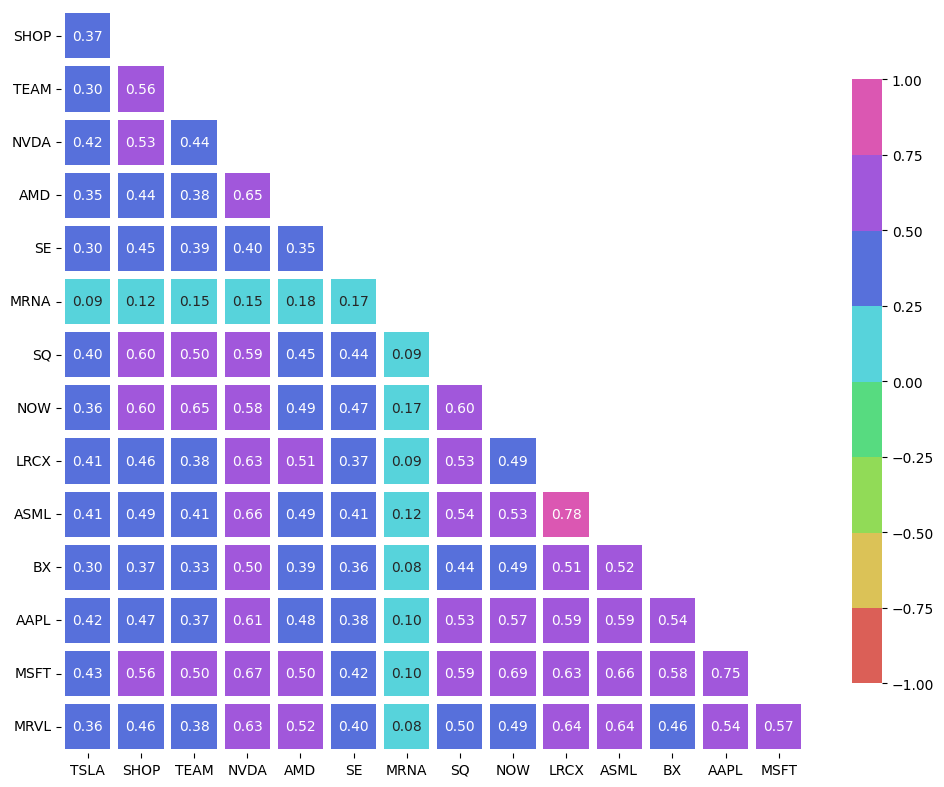

In [379]:
corr = returns.corr()

# Correlation heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=np.bool))

mask = mask[1:, :-1]
corr = corr.iloc[1:,:-1].copy()

cmap = sns.color_palette("hls", 8)

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)

yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

plt.show()

In [380]:
# Weights of each stock in the portfolio list. Will be random each time. 

num_stocks = len(port_list)
num_stocks

weights = np.random.random(num_stocks)
weights /= np.sum(weights)
print('Weights:', weights)
print('Total Weights:', np.sum(weights))


Weights: [0.01979818 0.09571531 0.04006529 0.0767747  0.01501735 0.07451262
 0.06354678 0.04616136 0.07423116 0.08784403 0.04637729 0.06677799
 0.1086067  0.0734525  0.11111875]
Total Weights: 1.0


In [384]:
#Return

np.sum(weights * returns.mean()) * 252 

#252 trading days, annualized return over 5 years of time with random weights, pecentage return based off a randomly generated portfolio.

0.40919490655336277

In [383]:
#Volatility

np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))   

#linear algebra of dot product, risk percentage based off a randomly generated portfolio.

0.31211772874133775

In [385]:
#Return and Risk of 10000 Combinations

p_ret = []   #return list
p_vol = []   #volatility risk, std from mean
p_SR = []
p_wt = []     #amt of each stock we have

for x in range(10000):
  p_weights = np.random.random(num_stocks)
  p_weights /= np.sum(p_weights)

  ret_1 = np.sum(p_weights * returns.mean()) * 252
  p_ret.append(ret_1)

  vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 252, p_weights)))
  p_vol.append(vol_1)

  SR_1 = (ret_1 - risk_free_rate) / vol_1
  p_SR.append(SR_1)

  p_wt.append(p_weights)

p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt




(array([0.40860881, 0.40024667, 0.41194778, ..., 0.43940557, 0.4436734 ,
        0.39434733]),
 array([0.31904728, 0.32086264, 0.32115073, ..., 0.32555392, 0.32265119,
        0.30150568]),
 array([1.24153642, 1.20845066, 1.24380159, ..., 1.31132062, 1.33634528,
        1.2664681 ]),
 array([[5.12121626e-02, 8.73140434e-02, 5.54487355e-03, ...,
         1.07923943e-01, 8.30111929e-02, 1.67844635e-02],
        [8.92669324e-05, 8.69949953e-03, 7.32890561e-02, ...,
         1.00419386e-01, 1.46386969e-01, 3.99482002e-02],
        [2.33467439e-02, 8.03387665e-03, 1.12075069e-01, ...,
         9.23540159e-02, 1.01659343e-01, 4.12272660e-02],
        ...,
        [1.41924443e-01, 1.26472099e-01, 4.05131025e-02, ...,
         6.06736081e-02, 2.21303267e-02, 9.22653179e-02],
        [7.87350227e-02, 1.03030787e-01, 1.07364511e-01, ...,
         1.68893469e-02, 4.93655033e-02, 6.41356505e-02],
        [1.31059228e-02, 1.78144793e-02, 1.10815760e-01, ...,
         1.02780468e-01, 5.21831265e-02,

        Return  Volatility
0     0.408609    0.319047
1     0.400247    0.320863
2     0.411948    0.321151
3     0.429388    0.329307
4     0.411197    0.329073
...        ...         ...
9995  0.423446    0.327067
9996  0.411791    0.322849
9997  0.439406    0.325554
9998  0.443673    0.322651
9999  0.394347    0.301506

[10000 rows x 2 columns]


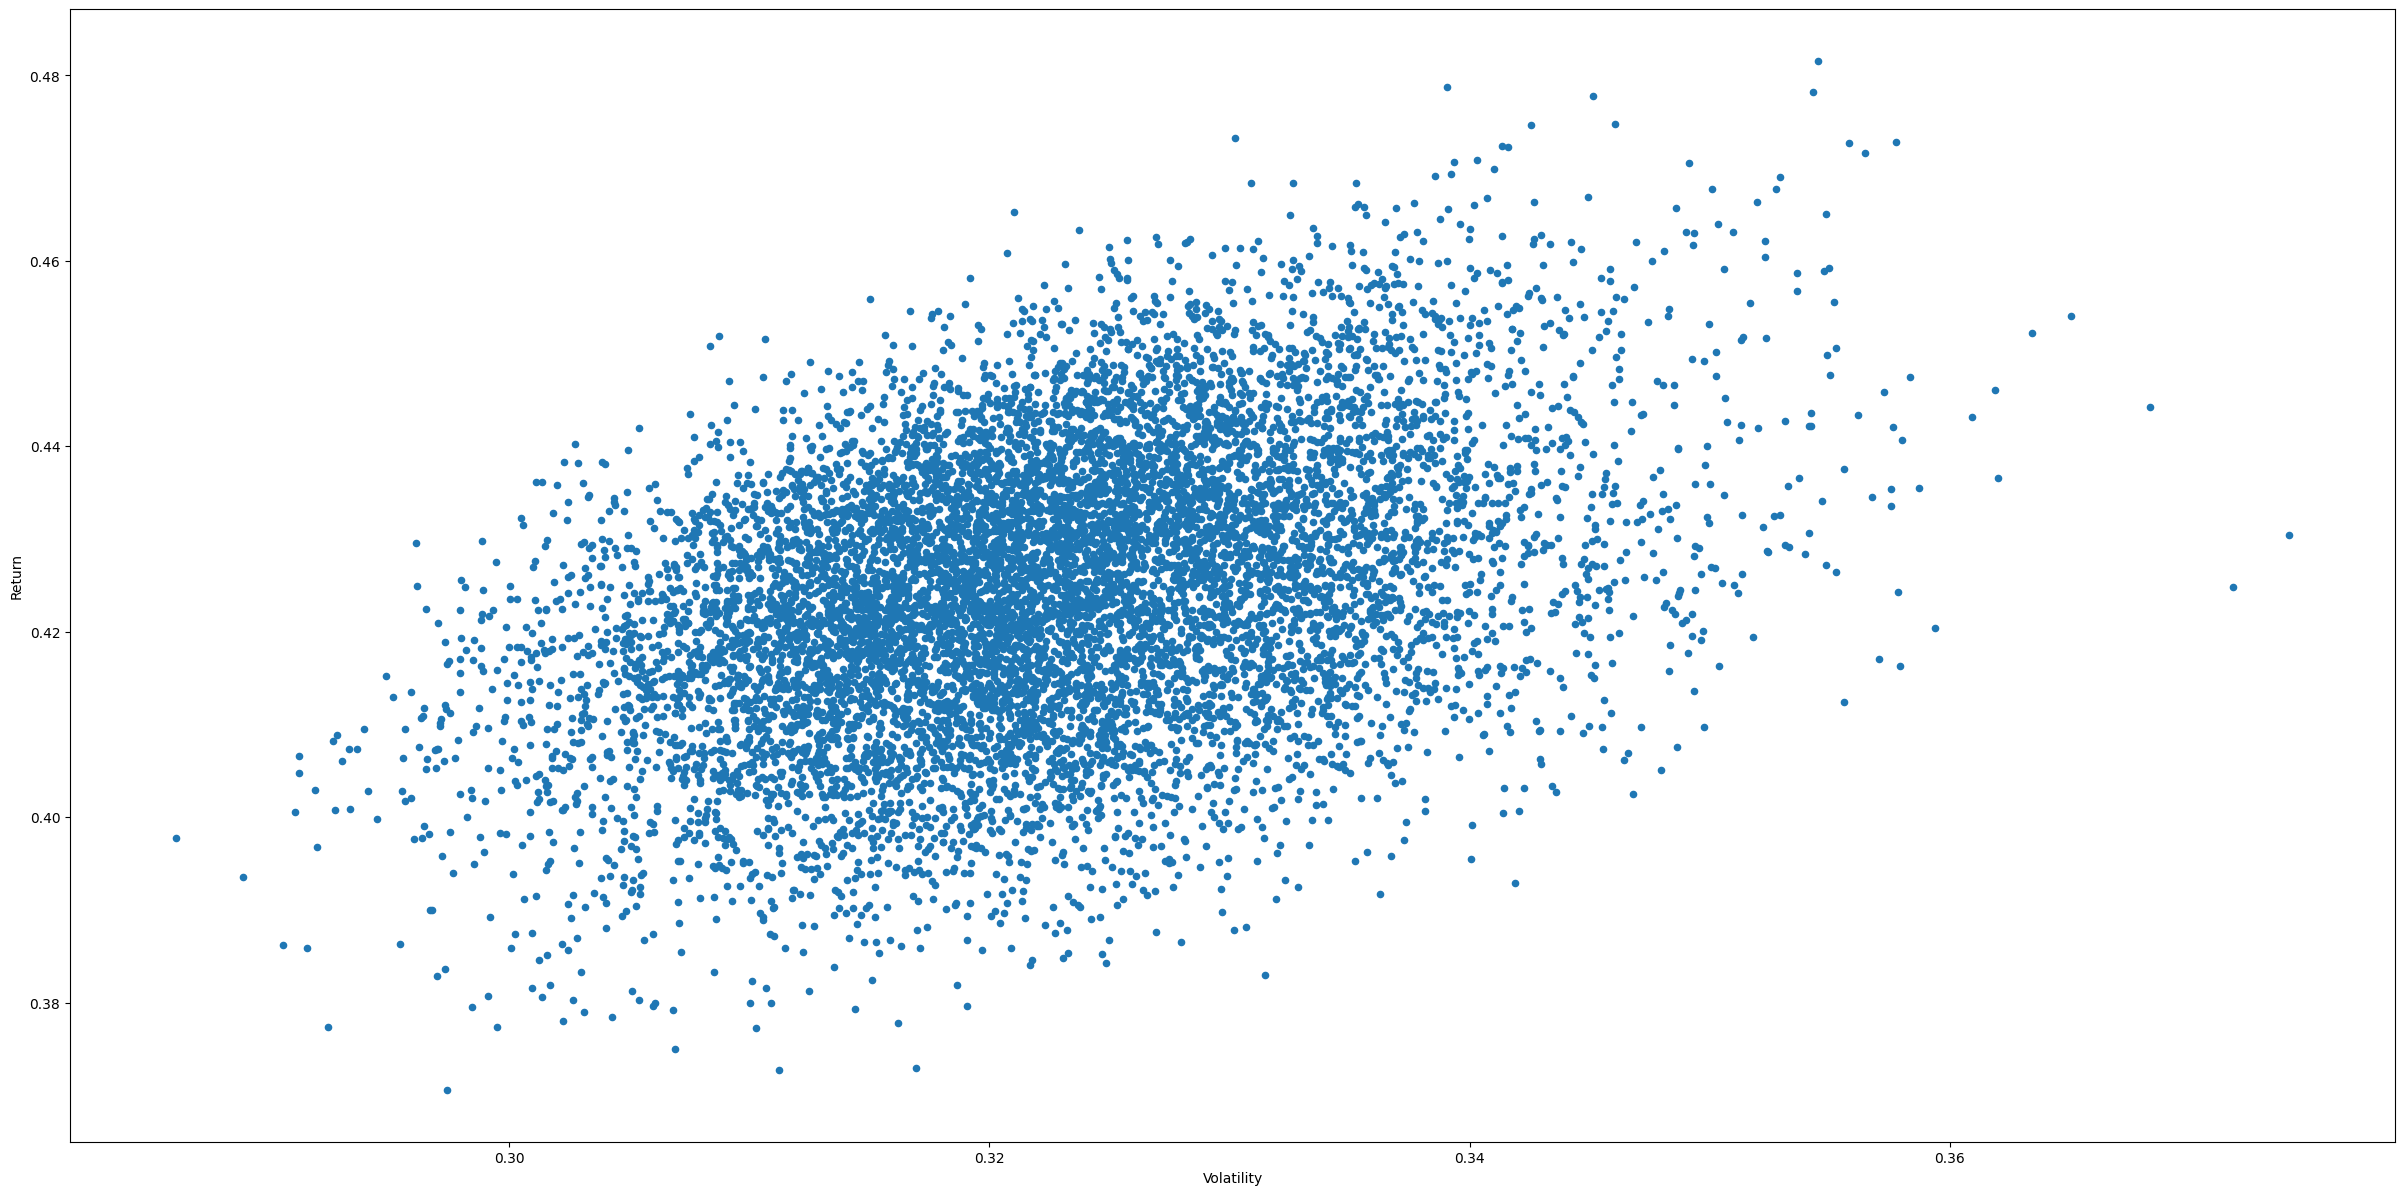

In [386]:
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})
print(ports)
ports.plot(x='Volatility', y='Return', kind='scatter', figsize=(30,15))


In [387]:
#Sharp Ratio

SR_idx = np.argmax(p_SR)

i = 0

while i < num_stocks: 
  print('Stock : %s : %2.2f' % (port_list[i],
                                (p_wt[SR_idx][i] * 100)))
  i+=1

print('\nVolatility:', p_vol[SR_idx])
print("Return: ", p_ret[SR_idx])

# percetenage for the stock, for example, you will buy costco for 19.71%

Stock : TSLA : 12.25
Stock : SHOP : 0.39
Stock : TEAM : 12.93
Stock : NVDA : 0.57
Stock : AMD : 4.11
Stock : SE : 13.66
Stock : MRNA : 12.51
Stock : SQ : 2.52
Stock : NOW : 1.58
Stock : LRCX : 0.31
Stock : ASML : 7.69
Stock : BX : 5.16
Stock : AAPL : 14.70
Stock : MSFT : 11.19
Stock : MRVL : 0.43

Volatility: 0.30871256524560453
Return:  0.4518348957268242


In [388]:
def get_port_shares(one_price, force_one, wts, prices):
  num_stocks = len(wts)
  shares = []

  cost_shares = []

  i = 0
  while i < num_stocks: 
    max_price = one_price * wts[i]
    num_shares = int(max_price / prices[i])
    if(force_one & (num_shares == 0)):
      num_shares = 1
    shares.append(num_shares)
    cost = num_shares * prices[i]
    cost_shares.append(cost)
    i += 1
  return shares, cost_shares

In [389]:
def get_port_weighting(share_cost):
    
    # Holds weights for stocks
    stock_wts = []
    # All values summed
    tot_val = sum(share_cost)
    print("Total Investment :", tot_val)
    
    for x in share_cost:
        stock_wts.append(x / tot_val)
    return stock_wts


In [390]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, 
                                  date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    return port_prices

In [391]:
#Convert the weights to percentage

port_wts = p_wt[SR_idx].tolist()
port_wts = [i*100 for i in port_wts]

port_wts

[12.252213224562821,
 0.3903280490161821,
 12.925158793211565,
 0.5670776514358078,
 4.112927104600632,
 13.66318129971912,
 12.507379605656247,
 2.5240940026837784,
 1.577981162653846,
 0.3076398809152339,
 7.6926020813913425,
 5.1556520057841455,
 14.7035636301246,
 11.19405056148457,
 0.42615094676011245]

In [400]:
#In the final output, we will need to find the price of the stock with the minimal weight (or weight closest to 1). This is the one_price of function get_port_shares(one_price, force_one, wts, prices)

def get_price_at_min_weight(ticker_list,weights,price):
  df = pd.DataFrame({'Ticker': ticker_list,
                   'Weights': weights,
                   'Price': price})

  min = df[df['Weights'] == df['Weights'].min()]
  min_price = min['Price']
  return(min_price)

get_price_at_min_weight(port_list, port_wts, port_prices)


9    591.469971
Name: Price, dtype: float64

In [393]:
# Getting the previous trading day and convert back to string to use in the next function.

from datetime import timedelta
 
# Get today's date
today = datetime.today()
 
# Yesterday date
yesterday = today - timedelta(days = 1)
yesterday = yesterday.strftime('%Y-%m-%d')
type(yesterday)
yesterday

'2022-02-16'

In [401]:
# Get all stock prices on the starting date
port_df_start = merge_df_by_column_name('Close',  yesterday, 
                                  yesterday, *port_list)

# Convert from dataframe to Python list
port_prices = port_df_start.values.tolist()

# Trick that converts a list of lists into a single list
port_prices = sum(port_prices, [])

tot_shares, share_cost = get_port_shares(get_price_at_min_weight(port_list, port_wts, port_prices), True, port_wts, port_prices)
print("Shares :", tot_shares)
print("Share Cost :", share_cost)

# Get list of weights for stocks
stock_wts = get_port_weighting(share_cost)
print("Stock Weights :", stock_wts)

# Get value at end of year
get_port_val_by_date(E_DATE, tot_shares, port_list)

Shares : [7, 1, 23, 1, 20, 57, 48, 13, 1, 1, 6, 24, 50, 22, 3]
Share Cost : [6463.730102539063, 746.8499755859375, 7330.329803466797, 265.1099853515625, 2353.8000488281245, 8070.060104370117, 7286.8798828125, 1417.0, 590.8900146484375, 591.469970703125, 3983.159912109375, 3042.719970703125, 8627.50015258789, 6589.0, 216.29999542236328]
Total Investment : 57574.79991912842
Stock Weights : [0.11226665332086685, 0.012971820599202936, 0.12731837216565642, 0.004604618439385725, 0.04088247031920831, 0.14016653320038638, 0.12656370309663093, 0.02461146199362165, 0.010262997274474637, 0.010273070362969988, 0.06918234918235515, 0.05284812061834407, 0.1498485477102201, 0.11444242983484337, 0.003756851881833473]


[]

#SUMMARY

In [402]:
port_df_start

,TSLA,SHOP,TEAM,NVDA,AMD,SE,MRNA,SQ,NOW,LRCX,ASML,BX,AAPL,MSFT,MRVL
Date,,,,,,,,,,,,,,,
2022-02-16,923.390015,746.849976,318.709991,265.109985,117.690002,141.580002,151.809998,109.0,590.890015,591.469971,663.859985,126.779999,172.550003,299.5,72.099998


In [403]:
print('Volatility:', p_vol[SR_idx]*100)
print('Return: ', p_ret[SR_idx]*100)
print('Total Share Needed: ', sum(tot_shares))
print('Total Share Cost: ', sum(share_cost))

Volatility: 30.871256524560454
Return:  45.183489572682426
Total Share Needed:  277
Total Share Cost:  57574.79991912842


In [404]:
df = pd.DataFrame({'Ticker': port_list,
                   'Weights': port_wts,
                   'Shares': tot_shares,
                   'Closing Price': port_prices,
                   'Share Cost': share_cost,
                   'Cumulative Return': top_10['CUM_RET'],
                   'Mean Return': mean_ret.tolist()})

df

,Ticker,Weights,Shares,Closing Price,Share Cost,Cumulative Return,Mean Return
5,TSLA,12.252213,7,923.390015,6463.730103,16.959740,56.706857
96,SHOP,0.390328,1,746.849976,746.849976,12.139954,50.009420
138,TEAM,12.925159,23,318.709991,7330.329803,10.662763,47.410407
6,NVDA,0.567078,1,265.109985,265.109985,10.019744,46.164427
72,AMD,4.112927,20,117.690002,2353.800049,8.963443,43.932822
140,SE,13.663181,57,141.580002,8070.060104,8.707257,50.125691
187,MRNA,12.507380,48,151.809998,7286.879883,8.161828,65.804225
171,SQ,2.524094,13,109.000000,1417.000000,7.532826,40.449612
92,NOW,1.577981,1,590.890015,590.890015,6.371469,37.095483
142,LRCX,0.307640,1,591.469971,591.469971,5.578610,34.433451
